In [21]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [22]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [23]:
directory = "/kaggle/input/procedural-environment-generation/dataset/dataset"
img_shape = (256,256,1)
img_paths = [directory + '/' + file for file in os.listdir(directory)]
img_paths = img_paths[:-6]
img_paths = np.sort(img_paths)

In [24]:
def load_images(img_paths):
    for image in img_paths:
        img = Image.open(image)
        img_array = np.array(img)
        img_array_normalized = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array))
        
        yield np.transpose(np.expand_dims(np.float32(img_array_normalized), axis = 2),(2,0,1))

In [25]:
def show_images(imgs, grid_size=5):
    fig = plt.figure(figsize = (9,9))
    plt.axis("off")
    plt.title("sample training images")
    images = load_images(imgs)
    columns = rows = grid_size
    for i in range(1, columns*rows +1):
        
        fig.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.imshow(np.transpose(next(images), (1,2,0)), cmap = 'gray')
        
    plt.show()

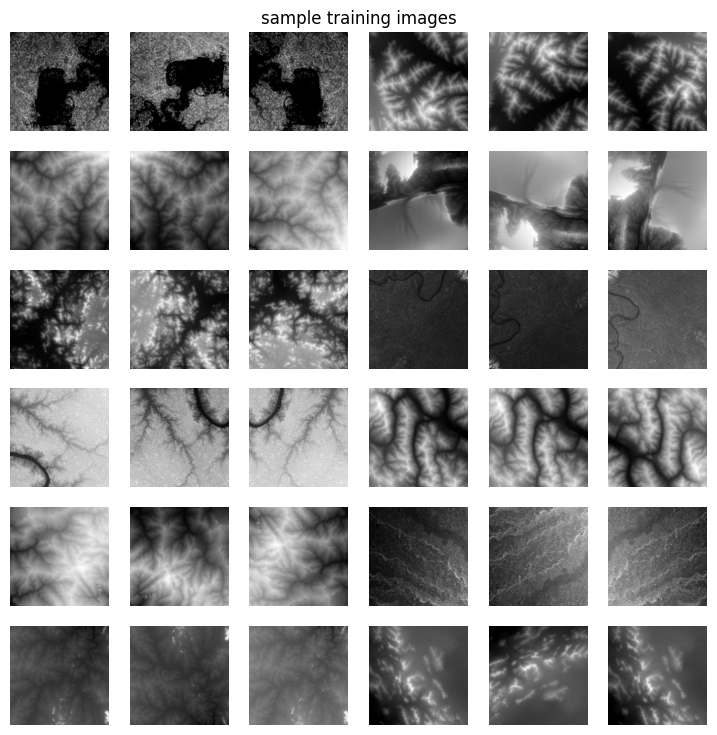

In [26]:
show_images(img_paths,6)

In [27]:
class Terrain(Dataset):
    def __init__(self, img_paths):
        self.img_paths = img_paths
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = next(load_images([self.img_paths[idx]]))
        return image

In [29]:
dataset = Terrain(img_paths)
batchsize = 64
shuffle = True

In [30]:
Batches = DataLoader(dataset = dataset, batch_size = batchsize, shuffle = shuffle)

In [31]:
dev = 'cuda:0' if torch.cuda.is_available() == True else 'cpu'
device = torch.device(dev)
print(dev)

cuda:0


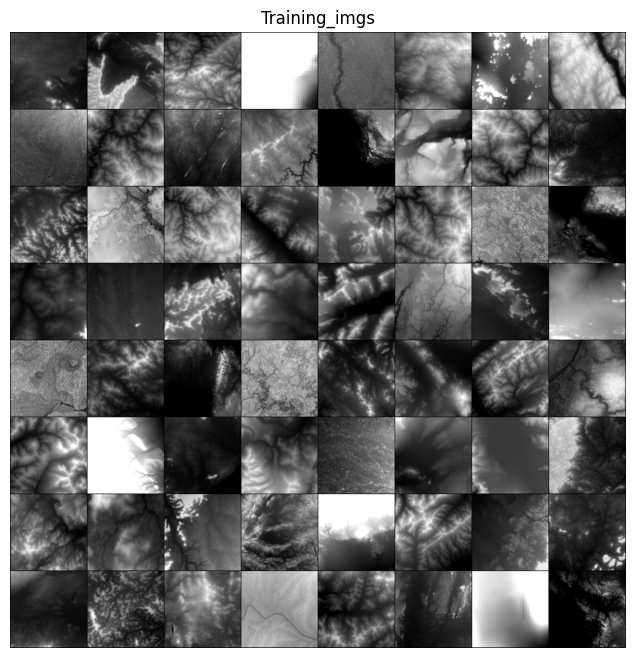

In [32]:
import torchvision.utils as vutils
batch = next(iter(Batches))
plt.figure(figsize = (8,8))
plt.axis("off")
plt.title("Training_imgs")
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding = 2, normalize=True).cpu(),(1,2,0)), cmap='gray')
plt.show()

In [33]:
class VAE(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64,momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128,momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.mean_layer = nn.Linear(256 * (256 // 16) * (256 // 16), latent_dim)
        self.log_var_layer = nn.Linear(256 * (256 // 16) * (256 // 16), latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * (256 // 16) * (256 // 16)),
            nn.ReLU(),
            nn.Unflatten(1, (256, 256 // 16, 256 // 16)),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(upscale_factor=2),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(upscale_factor=2),
            nn.BatchNorm2d(64, momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(upscale_factor=2),
            nn.BatchNorm2d(32, momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(upscale_factor=2),
            nn.BatchNorm2d(16, momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(16, input_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )



    def forward(self, x):
        x = self.encoder(x)
        mean = self.mean_layer(x)
        log_var = self.log_var_layer(x)

        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mean + eps * std

        x_reconstructed = self.decoder(z)

        return x_reconstructed, mean, log_var, z

In [35]:
class GAN(nn.Module):
    def __init__(self, latent_dim):
        super(GAN, self).__init__()

        # Generator
        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256 * (256 // 16) * (256 // 16)),
            nn.ReLU(),
            nn.Unflatten(1, (256, 256 // 16, 256 // 16)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

        # Discriminator
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128,momentum=0.9),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256,momentum=0.9),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * (256 // 16) * (256 // 16), 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        fake_images = self.generator(z)
        discriminator_output = self.discriminator(fake_images)
        return fake_images, discriminator_output

    

In [36]:
checkpoint_dir = 'model_checkpoints_real3'
os.makedirs(checkpoint_dir, exist_ok=True)

In [37]:
input_channels = 1  # Assuming grayscale height maps
latent_dim = 64
learning_rate_vae = 3e-4
learning_rate_gan = 3e-5
num_epochs = 10
gamma = 15

# Create VAE and GAN models, loss functions, and optimizers
vae = VAE(input_channels, latent_dim).to(device)
gan = GAN(latent_dim).to(device)
criterion_vae = nn.MSELoss().to(device)
criterion_gan = nn.BCELoss().to(device)
optim_E = optim.Adam(vae.parameters(), lr=learning_rate_vae)
optim_D = optim.Adam(vae.parameters(), lr=learning_rate_vae)
optim_Dis = optim.Adam(gan.parameters(), lr=learning_rate_gan)

[0/10][0/1319]	Loss_gan: 2.0918	Loss_prior: 80.3710	Rec_loss: 0.0090	dis_real_loss: 0.6101	dis_fake_loss: 0.7488	dis_prior_loss: 0.7329
[0/10][50/1319]	Loss_gan: 1.3937	Loss_prior: 2644.3445	Rec_loss: 0.0314	dis_real_loss: 0.6646	dis_fake_loss: 0.7015	dis_prior_loss: 0.0276
[0/10][100/1319]	Loss_gan: 2.2932	Loss_prior: 1699.4122	Rec_loss: 0.0778	dis_real_loss: 0.9610	dis_fake_loss: 1.3064	dis_prior_loss: 0.0259
[0/10][150/1319]	Loss_gan: 1.9826	Loss_prior: 269.3459	Rec_loss: 0.1056	dis_real_loss: 1.5013	dis_fake_loss: 0.1890	dis_prior_loss: 0.2923
[0/10][200/1319]	Loss_gan: 2.2839	Loss_prior: 646.7297	Rec_loss: 0.0763	dis_real_loss: 0.9895	dis_fake_loss: 0.6292	dis_prior_loss: 0.6652
[0/10][250/1319]	Loss_gan: 1.9351	Loss_prior: 629.9860	Rec_loss: 0.0618	dis_real_loss: 1.0452	dis_fake_loss: 0.5189	dis_prior_loss: 0.3710
[0/10][300/1319]	Loss_gan: 2.1619	Loss_prior: 1148.3308	Rec_loss: 0.0564	dis_real_loss: 1.1708	dis_fake_loss: 0.7421	dis_prior_loss: 0.2490
[0/10][350/1319]	Loss_gan: 2

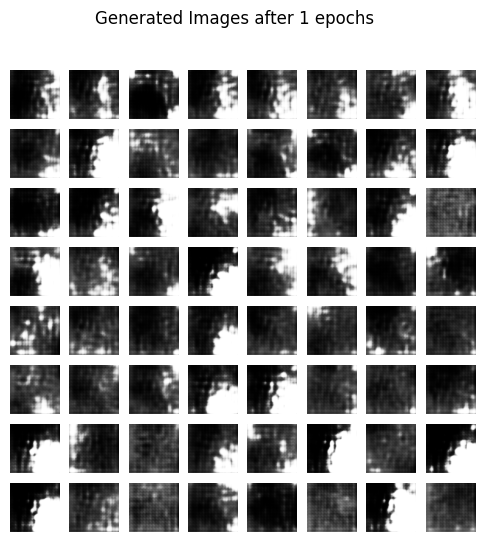

[1/10][0/1319]	Loss_gan: 1.6893	Loss_prior: 1126.3518	Rec_loss: 0.1067	dis_real_loss: 0.8095	dis_fake_loss: 0.4907	dis_prior_loss: 0.3891
[1/10][50/1319]	Loss_gan: 0.1497	Loss_prior: 0.4958	Rec_loss: 0.9252	dis_real_loss: 0.1282	dis_fake_loss: 0.0107	dis_prior_loss: 0.0107
[1/10][100/1319]	Loss_gan: 0.0585	Loss_prior: 0.2233	Rec_loss: 0.9697	dis_real_loss: 0.0437	dis_fake_loss: 0.0074	dis_prior_loss: 0.0074
[1/10][150/1319]	Loss_gan: 0.0906	Loss_prior: 0.1006	Rec_loss: 0.9484	dis_real_loss: 0.0828	dis_fake_loss: 0.0039	dis_prior_loss: 0.0039
[1/10][200/1319]	Loss_gan: 0.0636	Loss_prior: 0.0262	Rec_loss: 0.9499	dis_real_loss: 0.0328	dis_fake_loss: 0.0154	dis_prior_loss: 0.0154
[1/10][250/1319]	Loss_gan: 0.0567	Loss_prior: 0.0190	Rec_loss: 0.9709	dis_real_loss: 0.0489	dis_fake_loss: 0.0039	dis_prior_loss: 0.0039


In [ ]:
for epoch in range(num_epochs):
    prior_loss_list,gan_loss_list,recon_loss_list=[],[],[]
    dis_real_list,dis_fake_list,dis_prior_list=[],[],[]
    for i, (data) in enumerate(Batches):
        inputs = data.to(device)
        rec_enc, mean, logvar, z = vae(inputs)
        z_p = torch.randn(64,64).to(device) #creating some random input noise
        x_p_tilda = vae.decoder(z_p)
        
        #training the discriminator 
        output_real = gan.discriminator(inputs)    #with the real images
        errD_real = criterion_gan(output_real,torch.ones_like(output_real))
        dis_real_list.append(errD_real.item())
        
        output_fake = gan.discriminator(rec_enc)   #with the reconstructed images from our encoder
        errD_fake = criterion_gan(output_fake,torch.zeros_like(output_fake))
        dis_fake_list.append(errD_fake.item())
        
        output_noise = gan.discriminator(x_p_tilda)  #with the images constructed from the noise
        errD_rec_noise = criterion_gan(output_noise,torch.zeros_like(output_noise))
        dis_prior_list.append(errD_rec_noise.item())
        
        gan_loss = errD_real + errD_fake + errD_rec_noise
        gan_loss_list.append(gan_loss.item())
        optim_Dis.zero_grad()
        gan_loss.backward(retain_graph=True)
        optim_Dis.step()
        
        #training the decoder
        rec_loss = criterion_vae(output_fake, output_real)
        err_dec = gamma * rec_loss - gan_loss 
        recon_loss_list.append(rec_loss.item())
        optim_D.zero_grad()
        err_dec.backward(retain_graph=True)
        optim_D.step()
        
        #training the encoder
        prior_loss = 1 + logvar - mean.pow(2) - logvar.exp()  
        prior_loss = (-0.5 * torch.sum(prior_loss))
        prior_loss_list.append(prior_loss.item())
        err_enc = prior_loss + 3*rec_loss

        optim_E.zero_grad()
        err_enc.backward(retain_graph=True)
        optim_E.step()

        if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_gan: %.4f\tLoss_prior: %.4f\tRec_loss: %.4f\tdis_real_loss: %0.4f\tdis_fake_loss: %.4f\tdis_prior_loss: %.4f'
                      % (epoch,num_epochs, i, len(Batches),
                         gan_loss.item(), prior_loss.item(),rec_loss.item(),errD_real.item(),errD_fake.item(),errD_rec_noise.item()))
    with torch.no_grad():
        vae.eval()
        gan.eval()
        z_extracted = z
        generated_height_maps = vae.decoder(z_extracted.to(device)).squeeze().detach()
    
    generated_height_maps_np = (generated_height_maps * 255).clamp(0, 255).cpu().numpy()
    for i in range(2):
            image_name = f'generated_image_epoch_{epoch + 1}_sample_{i + 1}.png'
            image_path = os.path.join(checkpoint_dir, image_name)
            plt.imsave(image_path, generated_height_maps_np[i], cmap='gray')

    generated_height_maps_np_grid = generated_height_maps_np.reshape(8, 8, 256, 256)  # Assuming height and width are the dimensions of each image

    plt.figure(figsize=(6,6))
    for i in range(8):
        for j in range(8):
            plt.subplot(8, 8, i*8 + j + 1)
            plt.imshow(generated_height_maps_np_grid[i, j], cmap='gray')
            plt.axis('off')
    plt.suptitle(f'Generated Images after {epoch + 1} epochs')
    plt.show()
    
    
    if(epoch%2==0):
        checkpoint_vae = {
            'epoch': epoch,
            'model_state_dict': vae.state_dict(),
            'optimizer_E_dict': optim_E.state_dict(),
            'optimizer_D_dict': optim_D.state_dict(),
            'prior loss': prior_loss,
            'rec loss': rec_loss,

        }
        torch.save(checkpoint_vae, os.path.join(checkpoint_dir, f'vae_checkpoint_epoch_{epoch + 1}.pth'))

        checkpoint_gan = {
            'epoch': epoch,
            'model_state_dict': gan.state_dict(),
            'gan_loss': gan_loss,
            'optimizer_state_dict_dis': optim_Dis.state_dict(),
            'errD_Real': errD_real,
            'errD_Fake': errD_fake,
            'errD_rec_noise': errD_rec_noise

        }
        torch.save(checkpoint_gan, os.path.join(checkpoint_dir, f'gan_checkpoint_epoch_{epoch + 1}.pth'))

    
    

In [ ]:
def plot_loss(loss_list):
    plt.figure(figsize=(10,5))
    plt.title("Loss During Training")
    plt.plot(loss_list,label="Loss")
    
    plt.xlabel("iterations")
    plt.ylabel(f"Loss - {loss_list}")
    plt.legend()
    plt.show()

In [ ]:
plot_loss(prior_loss_list)
plot_loss(recon_loss_list)
plot_loss(gan_loss_list)